In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors
from scipy.stats import entropy, variation

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins, nbrh_WG_open
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
dico_garden_opening_hour = config.dico_garden_opening_hour
id_run = config.id_run
dico_matching = config.dico_matching
print(id_run)

change the configuration file if not done yet!
ALLDATA_


# Download data

In [4]:
#cleaned mvt data
df_init = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp', 'date']) 
print(df_init.shape)
df_init.head(3)

(2681720, 18)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,duration,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open,duration_mn,is_day
0,hen_1,pen9,8 - 9,2_Zone,1.0,2020-09-29 09:50:00,2020-09-29,2020-09-29 17:56:25,0 days 08:06:25,NaN,NaN,3_Zone,NaN,NaN,False,False,486.416667,True
1,hen_1,pen9,8 - 9,3_Zone,1.0,2020-09-29 17:56:25,2020-09-29,2020-09-30 09:55:59,0 days 02:52:35,2020-09-29 09:50:00,0 days 08:06:25,3_Zone,2_Zone,NaN,False,False,959.566667,False
2,hen_1,pen9,8 - 9,5_Zone,1.0,2020-09-30 09:55:59,2020-09-30,2020-09-30 11:34:30,0 days 01:32:11,2020-09-30 09:51:57,0 days 00:04:02,5_Zone,3_Zone,3_Zone,False,False,98.516667,True


In [5]:
#daily var
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
print(df_daily.shape)
df_daily.head(3)

(38714, 70)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB
0,hen_130,2020-10-05,NaN,0.0,0.0,0.0,32400.0,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",...,5_Zone,54000.0,0.0,0.0,9,True,124,18,6,1
1,hen_130,2020-10-06,NaN,0.0,780.0,325.0,31295.0,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",...,3_Zone,5363.0,1.0,1.0,9,True,125,18,7,1
2,hen_130,2020-10-07,NaN,206.0,249.0,130.0,31815.0,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",...,5_Zone,54000.0,0.0,0.0,9,True,126,18,8,2


#daily var IN BETWEEN CHECKS
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily__pen12_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
print(df_daily.shape)
df_daily.head(3)

In [6]:
print(df_daily[df_daily['vertical_travel_distance_dawn']==0].shape)
print(df_daily[df_daily['vertical_travel_distance_dawn']>0].shape)

(32745, 70)
(231, 70)


In [7]:
print(list(df_daily.columns))

['HenID', 'level', 'duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone', 'verification_daily_total_duration', 'verification_daily_total_nbr_hour', 'dur_values', 'dur_values_normalized', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone', 'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec', 'duration_sincedaystarted_beforeWGopened_sec', 'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone', 'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen', 'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone', 'list_of_durations', 'food_related_behavior', 'food_related_behavior_rp', 'food_related_behavior_rm', 'food_related_behavior4', 'food_related_behavior_rp4', 'food_related_behavior_rm4', 'nestboxes_related_behavior', 'list_of_zones', 'list_Z4', 'mid_cum_Z4_sec', 'Total_number_transition', 'nbr_stays', 'distribution_entropy', 'vertical_travel_dis

# Transformation - Could be added in UTILS if another run

In [8]:
#add tracking system ID
df_daily['TrackingSystemID'] = df_daily['PenID'].map(lambda x: config.dico_pen_ts[x])
display(df_daily['TrackingSystemID'].value_counts())

TrackingSystem 10-12    14847
TrackingSystem 3-5      14096
TrackingSystem 8-9       9771
Name: TrackingSystemID, dtype: int64

In [9]:
#add if animal is sleeping up 
df_daily['Is_Sleeping_UP'] = df_daily['night_Max_duration_zones'].isin(['5_Zone','4_Zone'])
display(df_daily['Is_Sleeping_UP'].value_counts(normalize=True))
#better than binary: height of sleeping
print(df_daily.shape)
df_daily = df_daily[~df_daily['night_Max_duration_zones'].isnull()]
df_daily['SleepingHeight'] = df_daily['night_Max_duration_zones'].map(lambda x: int(x.split('_')[0])-2)#-2: litter (zon2: equal to 0 tiers underneath)
display(df_daily['SleepingHeight'].value_counts(normalize=True))

True     0.821434
False    0.178566
Name: Is_Sleeping_UP, dtype: float64

(38714, 72)


3    0.694275
1    0.165051
2    0.136624
0    0.004050
Name: SleepingHeight, dtype: float64

#nbr transitions per hour. 
#df_daily['nbr_h_WGopen'] = df_daily['level'].map(lambda x: nbrh_WG_open(x, config))
li_ = ['vertical_travel_distance','nbr_stays_2_Zone','nbr_stays_3_Zone','nbr_stays_4_Zone','nbr_stays_5_Zone']
for v in li_:
    df_daily[v+'_perh'] = df_daily.apply(lambda x: x[v]/x['nbr_h_per_day'], axis=1)
    df_daily['nbr_stays_1_Zone_perh'] = df_daily.apply(lambda x: x['nbr_stays_1_Zone']/x['nbr_h_WGopen'] if x['nbr_h_WGopen']!=0 else np.nan, axis=1)
df_daily[['vertical_travel_distance_perh','vertical_travel_distance', 'nbr_stays_3_Zone', 'nbr_stays_3_Zone_perh',
        'nbr_h_per_day']].tail(3)

#uncommon/extreme behavior
df_daily['uncommon_behavior'] = df_daily.apply(lambda x: sum([x['Total_number_zone']<=2])>=1, axis=1)
display(df_daily[df_daily['level']>dt.datetime(2020,11,10)]['uncommon_behavior'].value_counts(normalize=True))
df_daily[(df_daily['uncommon_behavior']>0)&(df_daily['level']>dt.datetime(2020,11,10))][['level','HenID','uncommon_behavior','SleepingHeight','nestboxes_related_behavior',
                                           'Total_number_zone']].head(5)

#uncommon/extreme behavior
df_daily['uncommon_behavior'] = df_daily.apply(lambda x: sum([x['SleepingHeight'] in [0,1], 
                                                              x['nestboxes_related_behavior']<0,
                                                              x['Total_number_zone']<=2,
                                                              x['duration_4_Zone']<15*60])>=1, axis=1)
display(df_daily[df_daily['level']>dt.datetime(2020,11,10)]['uncommon_behavior'].value_counts(normalize=True))
df_daily[(df_daily['uncommon_behavior']>0)&(df_daily['level']>dt.datetime(2020,11,10))][['level','HenID','uncommon_behavior','SleepingHeight','nestboxes_related_behavior',
                                           'Total_number_zone']].head(5)

,list_Z4,mid_cum_Z4_sec,nbr_h_per_day,time_midduratioZ4_h
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,9,NaN
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1474.0,9,NaN
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",520.0,9,NaN


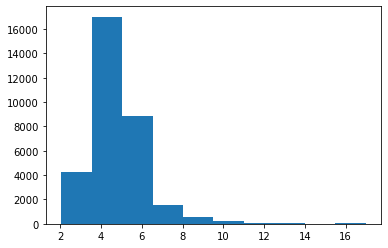

In [10]:
#only since 2h start in the morning
df_daily['time_midduratioZ4_h'] = df_daily['mid_cum_Z4_sec'].map(lambda x: x/60/60+2)
df_daily.loc[df_daily['level']<dt.datetime(2020,11,13,0,0,0),'time_midduratioZ4_h'] = np.nan
plt.hist(df_daily['time_midduratioZ4_h']);
df_daily[['list_Z4', 'mid_cum_Z4_sec','nbr_h_per_day','time_midduratioZ4_h']].head(3)

### add vertical distance full light and /inside hour

In [11]:
#add vertical travel distance during full light
df_daily['vertical_travel_distance_fulllight'] = df_daily.apply(lambda x: x['vertical_travel_distance']-x['vertical_travel_distance_dusk'], axis=1)
df_daily['vertical_travel_distance_fulllight_perinsideh'] = df_daily.apply(lambda x: x['vertical_travel_distance_fulllight']/(15-x['duration_1_Zone']/60/60),axis=1)

# add order of going to the litter in the morning

In [12]:
#sorted so that smallest comes first
dico_level_sortedlistdate = dict(df_daily.groupby(['level','PenID'])['FirstTimestamp_2_Zone'].agg(lambda x: sorted([i for i in list(x) if i is not pd.NaT])))
df_daily['order_firstlitter'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['FirstTimestamp_2_Zone']) if x['FirstTimestamp_2_Zone'] is not pd.NaT else np.nan, axis=1)
df_daily['order_firstlitter_percent'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['FirstTimestamp_2_Zone'])/\
                                           len(dico_level_sortedlistdate[(x['level'],x['PenID'])]) if x['FirstTimestamp_2_Zone'] is not pd.NaT else np.nan, axis=1)

#small verification
df_daily[df_daily['PenID']==10][['order_firstlitter','order_firstlitter_percent','FirstTimestamp_2_Zone','level','PenID',
                                 'HenID']].sort_values(['FirstTimestamp_2_Zone'])

,order_firstlitter,order_firstlitter_percent,FirstTimestamp_2_Zone,level,PenID,HenID
3290,0.0,0.000000,2020-09-30 09:00:00,2020-09-30,10,hen_54
874,0.0,0.000000,2020-09-30 09:00:00,2020-09-30,10,hen_140
4233,0.0,0.000000,2020-09-30 09:00:00,2020-09-30,10,hen_65
3066,3.0,0.176471,2020-09-30 09:01:16,2020-09-30,10,hen_46
4744,4.0,0.235294,2020-09-30 09:04:55,2020-09-30,10,hen_70
...,...,...,...,...,...,...
4797,NaN,NaN,NaT,2020-10-05,10,hen_78
4799,NaN,NaN,NaT,2020-10-07,10,hen_78
4801,NaN,NaN,NaT,2020-10-11,10,hen_78
4802,NaN,NaN,NaT,2020-10-12,10,hen_78


In [13]:
#verify that when an animal slept in the litter then its the first animal to be in litter.
#find such instance (i.e. the day after sleeping height=0!)
display(df_daily[(df_daily['SleepingHeight']==0)&(df_daily['PenID']==10)][['order_firstlitter','order_firstlitter_percent',
                                                                   'FirstTimestamp_2_Zone','level','PenID','HenID',
                                                                   'SleepingHeight']])
df_daily[(df_daily['level'].isin([dt.datetime(2020,10,6),dt.datetime(2020,10,16),dt.datetime(2020,10,22),
                                  dt.datetime(2020,10,28)]))&(df_daily['HenID']=='hen_143')][['order_firstlitter','order_firstlitter_percent',
                                                                   'FirstTimestamp_2_Zone','level','PenID','HenID',
                                                                   'SleepingHeight']]
#correct!

,order_firstlitter,order_firstlitter_percent,FirstTimestamp_2_Zone,level,PenID,HenID,SleepingHeight
119,NaN,NaN,NaT,2020-10-07,10,hen_134,0
459,12.0,0.600000,2021-01-09 02:22:23,2021-01-09,10,hen_138,0
462,11.0,0.550000,2021-01-12 02:12:22,2021-01-12,10,hen_138,0
832,2.0,0.100000,2021-05-20 02:08:43,2021-05-20,10,hen_139,0
881,2.0,0.117647,2020-10-10 08:12:29,2020-10-10,10,hen_140,0
1241,10.0,0.769231,2020-10-05 11:22:06,2020-10-05,10,hen_143,0
1243,14.0,0.933333,2020-10-07 13:37:10,2020-10-07,10,hen_143,0
1247,13.0,0.684211,2020-10-15 09:57:44,2020-10-15,10,hen_143,0
1253,19.0,0.950000,2020-10-21 17:04:41,2020-10-21,10,hen_143,0
1259,4.0,0.200000,2020-10-27 05:07:20,2020-10-27,10,hen_143,0


,order_firstlitter,order_firstlitter_percent,FirstTimestamp_2_Zone,level,PenID,HenID,SleepingHeight
1242,0.0,0.0,2020-10-06 09:00:00,2020-10-06,10,hen_143,3
1248,0.0,0.0,2020-10-16 07:00:00,2020-10-16,10,hen_143,2
1254,0.0,0.0,2020-10-22 06:00:00,2020-10-22,10,hen_143,2
1260,0.0,0.0,2020-10-28 05:00:00,2020-10-28,10,hen_143,1


# add order of going to the top floor in the evening

In [15]:
#compute last timestamp:
#why: will be usefull to produce other variables, to verify the code and to use it for some zones
df_ = df_init[df_init['Zone']=='5_Zone'].groupby(['HenID', 'date'])['Timestamp'].agg(lambda x: max(list(x))).reset_index()
df_.rename(columns={'Timestamp':'LastTimestampToptier','date':'level'}, inplace=True)
display(df_)
df_daily = pd.merge(df_daily, df_, how='left', on=['HenID','level'])

,HenID,level,LastTimestampToptier
0,hen_1,2020-09-30,2020-09-30 17:52:14
1,hen_1,2020-10-01,2020-10-01 13:49:30
2,hen_1,2020-10-02,2020-10-02 12:03:49
3,hen_1,2020-10-06,2020-10-06 15:25:37
4,hen_1,2020-10-07,2020-10-07 09:16:48
...,...,...,...
43172,hen_99,2021-06-07,2021-06-07 16:42:06
43173,hen_99,2021-06-08,2021-06-08 16:51:02
43174,hen_99,2021-06-09,2021-06-09 16:48:21
43175,hen_99,2021-06-10,2021-06-10 21:45:47


In [16]:
#ATTENTION: LastTimestampToptier does not mean that the bird stayed there after!! so have to be combined with their sleeping height
#Note that if the hen arrived up at 16h59, but then was kikked away at 17h01: we dont care as long as its sleeping height is the top floor.
#sorted so that smallest comes first
dico_level_sortedlistdate = dict(df_daily.groupby(['level','PenID'])['LastTimestampToptier'].agg(lambda x: sorted([i for i in list(x) if i is not pd.NaT])))
df_daily['order_firstgoingup'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['LastTimestampToptier']) if x['LastTimestampToptier'] is not pd.NaT else np.nan, axis=1)
df_daily['order_firstgoingup_percent'] = df_daily.apply(lambda x: dico_level_sortedlistdate[(x['level'],x['PenID'])].index(x['LastTimestampToptier'])/\
                                           len(dico_level_sortedlistdate[(x['level'],x['PenID'])]) if x['LastTimestampToptier'] is not pd.NaT else np.nan, axis=1)
df_daily['LastTimestampToptier_time'] = df_daily['LastTimestampToptier'].map(lambda x: dt.datetime.time(x))
#small verification
df_daily[df_daily['PenID']==10][['order_firstgoingup','order_firstgoingup_percent','LastTimestampToptier','LastTimestampToptier_time',
                                 'level','PenID','HenID','SleepingHeight']].sort_values(['LastTimestampToptier'])
#ISSUE: might not be there anymore!!! should be done with ts!!!!! but then waht if an animal arrive when its dark? bold or not?

,order_firstgoingup,order_firstgoingup_percent,LastTimestampToptier,LastTimestampToptier_time,level,PenID,HenID,SleepingHeight
1119,0.0,0.000000,2020-09-30 09:40:44,09:40:44,2020-09-30,10,hen_141,1
3438,1.0,0.066667,2020-09-30 10:16:19,10:16:19,2020-09-30,10,hen_57,3
616,2.0,0.133333,2020-09-30 10:23:37,10:23:37,2020-09-30,10,hen_139,3
1725,3.0,0.200000,2020-09-30 11:19:56,11:19:56,2020-09-30,10,hen_161,3
113,4.0,0.266667,2020-09-30 12:40:48,12:40:48,2020-09-30,10,hen_134,3
...,...,...,...,...,...,...,...,...
4758,NaN,NaN,NaT,00:00:00,2020-10-02,10,hen_78,3
4759,NaN,NaN,NaT,00:00:00,2020-10-04,10,hen_78,3
4760,NaN,NaN,NaT,00:00:00,2020-10-05,10,hen_78,3
4764,NaN,NaN,NaT,00:00:00,2020-10-11,10,hen_78,3


In [17]:
#would be 0 if they did not slept up, 1 would mean and 
#in that case, the bird that went up at 6h30 or the one that did not slept in top tier have the save value:30
df_daily['lastminutessleepingUP'] = df_daily.apply(lambda x: x['SleepingHeight']==3 & x['LastTimestampToptier']>, axis=1)

SyntaxError: invalid syntax (Temp/ipykernel_10916/3679565740.py, line 3)

#(day_Z5 /day – night_Z5/night) / (day_Z5 /day + night_Z5/night)
def Z5_diurnality(dur_day, dur_night, nbr_h_per_day):
    n = dur_day/nbr_h_per_day - dur_night/(24-nbr_h_per_day)
    p = dur_day/nbr_h_per_day + dur_night/(24-nbr_h_per_day)
    #if never spent time in Z5 then return: neutral nght versus day behavior
    if p==0:
        return 0
    return n/p  

df_daily['Z5diuranility'] = df_daily.apply(lambda x: Z5_diurnality(dur_day=x['duration_5_Zone'],
                                                                   dur_night=x['night_duration_Z5'],
                                                                   nbr_h_per_day=x['nbr_h_per_day']), axis=1)
plt.hist(df_daily['Z5diuranility']);
df_daily[['night_duration_Z5','duration_5_Zone','Z5diuranility']].tail(5)

#coefficient of variation: ratio of standard deviation to mean. np.std(x) / np.mean(x)
df_daily['CVduration'] = df_daily['list_of_durations'].map(lambda x: variation(eval(x)))
display(df_daily[df_daily['CVduration'].isnull()])
df_daily[['list_of_durations','list_of_zones','latency_1_Zone_h','latency_4_Zone_h','latency_2_Zone_h','CVduration']]
plt.hist(df_daily['CVduration']);

# Correct food reactivity index

In [18]:
#food_related_behavior should be replaced by food_related_behavior4 from the 28.03.2021 due to summer time changed that
#probably changed the computer programe timing too
df_daily['food_related_behavior_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_related_behavior'], df_daily['food_related_behavior4'])

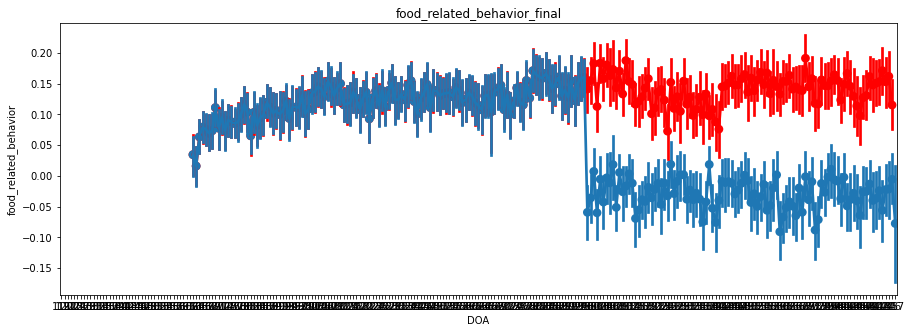

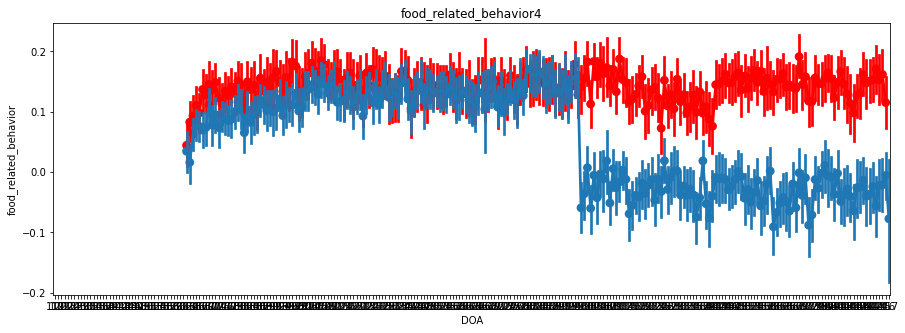

In [19]:
#small verification: CORRECT!
li_food = ['food_related_behavior_final','food_related_behavior4']
for b in li_food:
    plt.figure(figsize=(15,5))
    sns.pointplot(y=b, x='DOA', color='red', data=df_daily);
    sns.pointplot(y='food_related_behavior', x='DOA',  data=df_daily);
    plt.title(b)
    plt.show();

In [20]:
#food_related_behavior should be replaced by food_related_behavior4 from the 28.03.2021 due to summer time changed that
#probably changed the computer programe timing too
df_daily['food_related_behavior_rp_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_related_behavior_rp'], df_daily['food_related_behavior_rp4'])
df_daily['food_related_behavior_rm_final'] = np.where(df_daily['level']<dt.datetime(2021,3,27,0,0,0), 
                                                   df_daily['food_related_behavior_rm'], df_daily['food_related_behavior_rm4'])

In [34]:
np.std([1,2,3,4])

1.118033988749895

,HenID,WOA,level,variable,food_behavior
0,hen_131,24,2020-11-14,food_related_behavior_final,0.141396
1,hen_131,24,2020-11-15,food_related_behavior_final,0.156883
2,hen_131,24,2020-11-16,food_related_behavior_final,-0.225432


,variable,level,is_positive
0,food_related_behavior_final,2020-11-14,55.555556
1,food_related_behavior_final,2020-11-15,64.052288
2,food_related_behavior_final,2020-11-16,74.509804


,variable,mean_is_positive,sd_is_positive
0,food_related_behavior_final,71.688049,8.034954
1,food_related_behavior_rm_final,49.954698,9.378602
2,food_related_behavior_rp_final,50.142453,7.565089


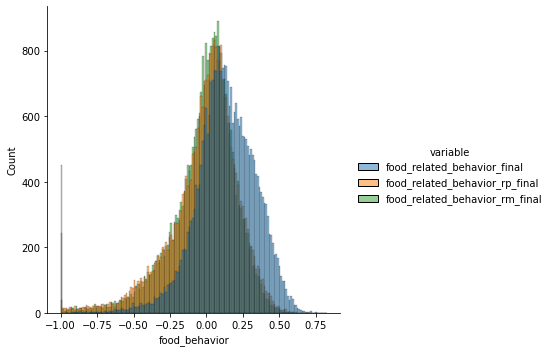

In [37]:
df_plt = pd.melt(df_daily[df_daily['level']>config.date_consistent_barn_schedule], id_vars=['HenID','WOA','level'], 
        value_vars=['food_related_behavior_final','food_related_behavior_rp_final','food_related_behavior_rm_final'],
        value_name='food_behavior')
display(df_plt.head(3))
sns.displot(df_plt, x='food_behavior', kde=False, hue='variable');
df_plt['is_positive'] = df_plt['food_behavior'].map(lambda x: x>0)
#display(df_plt.groupby(['variable'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index())
df_plt_ = df_plt.groupby(['variable','level'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index()
display(df_plt_.head(3))
df_plt_.groupby(['variable']).agg(mean_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.nanmean(x)),
           sd_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.std(x))).reset_index()
#weekly average +-SD of the mean daily food-related behavior across individuals

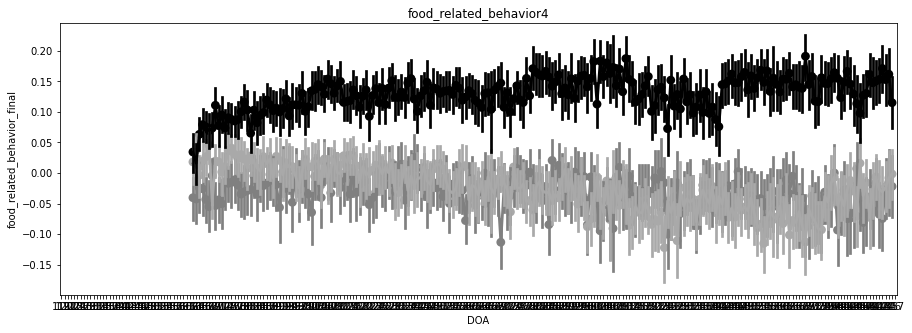

In [28]:
plt.figure(figsize=(15,5))
sns.pointplot(y='food_related_behavior_rp_final', x='DOA', color='grey', data=df_daily);
sns.pointplot(y='food_related_behavior_rm_final', x='DOA', color='darkgrey', data=df_daily);
sns.pointplot(y='food_related_behavior_final', x='DOA', color='black', data=df_daily);
plt.title(b)
plt.show();

In [ ]:
CACA TODO

# Dates tracked and name

In [10]:
#verify this was remove
df_daily[~((df_daily['level']<dt.datetime(2021,6,14))|(df_daily['level']>dt.datetime(2021,7,3)))]

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB,TrackingSystemID,Is_Sleeping_UP,SleepingHeight,time_midduratioZ4_h


In [11]:
#verify this was remove
df_daily[((df_daily['HenID']=='hen_158')&(df_daily['level']>dt.datetime(2021,5,1)))]

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB,TrackingSystemID,Is_Sleeping_UP,SleepingHeight,time_midduratioZ4_h


In [12]:
#verify this was remove
df_daily[((df_daily['HenID']=='hen_56')&(df_daily['level']>dt.datetime(2020,11,29))&\
                    (df_daily['level']<dt.datetime(2021,1,4)))]

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB,TrackingSystemID,Is_Sleeping_UP,SleepingHeight,time_midduratioZ4_h


In [13]:
#verify hen_129 is not here althought it was in focal bird with 0 workign tracked days!
if df_daily[df_daily['HenID']=='hen_129'].shape[0]>0:
    print('ERROR')
    sys.exit()
df_daily[df_daily['HenID']=='hen_129']

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB,TrackingSystemID,Is_Sleeping_UP,SleepingHeight,time_midduratioZ4_h


In [14]:
df_daily[df_daily['level']==dt.datetime(2020,9,30)][['PenID','nbr_h_per_day','correct_amount_of_hour','level']].head(5)

,PenID,nbr_h_per_day,correct_amount_of_hour,level
3,10,8,True,2020-09-30
114,10,8,True,2020-09-30
370,10,8,True,2020-09-30
625,10,8,True,2020-09-30
881,10,8,True,2020-09-30


In [15]:
df_daily[['PenID','nbr_h_per_day','correct_amount_of_hour','level','Total_number_transition','verification_daily_total_duration']].head(5)

,PenID,nbr_h_per_day,correct_amount_of_hour,level,Total_number_transition,verification_daily_total_duration
0,10,9,True,2020-10-05,0.0,32400.0
1,10,9,True,2020-10-06,3.0,32400.0
2,10,9,True,2020-10-07,4.0,32400.0
3,10,8,True,2020-09-30,5.0,28800.0
4,10,9,True,2020-10-01,9.0,32400.0


In [16]:
df_daily[['level','DIB','WIB','DOA','WOA']].head(5)

,level,DIB,WIB,DOA,WOA
0,2020-10-05,6,1,124,18
1,2020-10-06,7,1,125,18
2,2020-10-07,8,2,126,18
3,2020-09-30,1,1,119,17
4,2020-10-01,2,1,120,18


# Daily Variables

In [17]:
li_var = list(df_daily.columns)
li_general = ['HenID', 'level','PenID']
li_var_TODO = li_var #keep track of the columns that still needs to be verified
len(li_var_TODO)
#display(list(li_var))

71

In [18]:
#print all column with nan
#df_daily.columns[df_daily.isna().any()].tolist()

## Hens variables + disturbances days

In [19]:
li_hens = ['CLASS','TagID','FocalLegringName','R-Pen','InitialStartDate']
print(li_hens)

['CLASS', 'TagID', 'FocalLegringName', 'R-Pen', 'InitialStartDate']


In [20]:
#specific bird (in pen 9, should not be  here on the 3,4,5, 8, 9 th of OCtober it should have NO data at all
h = 'hen_90'
d = dt.datetime(2020,10,10)
df_daily[(df_daily['HenID']==h)&(df_daily['level']<=d)][li_general+li_hens+['duration_5_Zone',
                                                                            'night_Max_duration_zones']].sort_values(['level'])

,HenID,level,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate,duration_5_Zone,night_Max_duration_zones
38863,hen_90,2020-09-30,9,LEXP,tag_104,13green,3.0,2020-06-12 00:00:00,0.0,5_Zone
38864,hen_90,2020-10-01,9,LEXP,tag_104,13green,3.0,2020-06-12 00:00:00,783.0,3_Zone
38865,hen_90,2020-10-02,9,LEXP,tag_104,13green,3.0,2020-06-12 00:00:00,0.0,3_Zone
38866,hen_90,2020-10-06,9,LEXP,tag_104,13green,3.0,2020-06-12 00:00:00,31451.0,5_Zone
38867,hen_90,2020-10-07,9,LEXP,tag_104,13green,3.0,2020-06-12 00:00:00,32400.0,5_Zone
38868,hen_90,2020-10-10,9,LEXP,tag_104,13green,3.0,2020-06-12 00:00:00,35275.0,5_Zone


In [21]:
#verify that the day with weird device day (can be find here: *_df_alldeviceinfo) are removed
#hen_147 - tag 82: 25.01-03.02 not working (due to rfid installation and then tag bugging) 
h = 'hen_147'
dmin = dt.datetime(2021,1,24)
dmax = dt.datetime(2021,2,10)
df_daily[(df_daily['HenID']==h)&(df_daily['level']<=dmax)&(df_daily['level']>=dmin)][li_general+li_hens].sort_values(['level'])
#TO CHECK: Pen ID here even when the day variables is not here?
#TO DO AT THE END OF THE STUDY: check each indivudal case of GAP: e.g. tag 171 (hen 133) had big gaps on the 11.01.2021
#sometimes its nan due to the student that wrote +-30/70 (weight 04-01-2021, pen 12)
#CORRECT!

,HenID,level,PenID,CLASS,TagID,FocalLegringName,R-Pen,InitialStartDate
30886,hen_147,2021-01-24,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30887,hen_147,2021-02-03,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30888,hen_147,2021-02-04,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30889,hen_147,2021-02-05,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30890,hen_147,2021-02-06,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30891,hen_147,2021-02-07,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30892,hen_147,2021-02-08,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30893,hen_147,2021-02-09,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00
30894,hen_147,2021-02-10,8,MEXP,tag_82,43black,4.0,2020-06-10 00:00:00


In [22]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_hens]
len(li_var_TODO)

66

# food related behavior

,HenID,level,DIB,variable,food_behavior
0,hen_130,2020-10-05,6,food_related_behavior,NaN
1,hen_130,2020-10-06,7,food_related_behavior,NaN
2,hen_130,2020-10-07,8,food_related_behavior,NaN


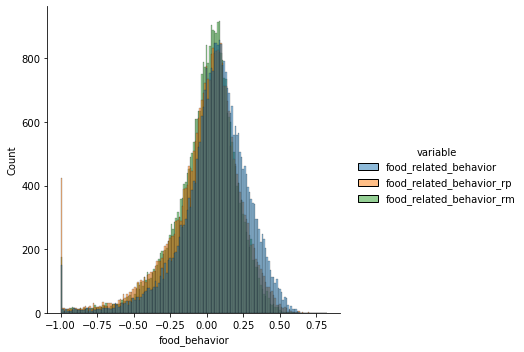

In [26]:
df_plt = pd.melt(df_daily, id_vars=['HenID','level','DIB'], 
        value_vars=['food_related_behavior','food_related_behavior_rp','food_related_behavior_rm'],
        value_name='food_behavior')
display(df_plt.head(3))
sns.displot(df_plt, x='food_behavior', kde=False, hue='variable');

In [27]:
#will be better checked visually in 4.b. notebook (more easy)
display(df_daily[df_daily['food_related_behavior']>0.5].tail(3))
h = 'hen_29'
d = dt.datetime(2020,10,19)
df = df_init[(df_init['HenID']==h)&((df_init['date']==d)|(df_init['date']==(d+dt.timedelta(days=1))))]
display(df_daily[(df_daily['HenID']==h)&((df_daily['level']==d)|(df_daily['level']==(d+dt.timedelta(days=1))))][li_general+['food_related_behavior']].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB,TrackingSystemID,Is_Sleeping_UP,SleepingHeight,time_midduratioZ4_h
36952,hen_190,2021-02-10,2358.0,31782.0,7809.0,5741.0,6310.0,54000.0,15.0,"[2358.0, 31782.0, 7809.0, 5741.0, 6310.0]",...,15,True,252,36,134,20,TrackingSystem 8-9,True,3,5.209444
36993,hen_190,2021-03-24,712.0,33547.0,8976.0,6952.0,3813.0,54000.0,15.0,"[712.0, 33547.0, 8976.0, 6952.0, 3813.0]",...,15,True,294,42,176,26,TrackingSystem 8-9,True,3,5.134722
39569,hen_98,2021-05-05,1675.0,27934.0,8059.0,7193.0,9139.0,54000.0,15.0,"[1675.0, 27934.0, 8059.0, 7193.0, 9139.0]",...,15,True,336,48,218,32,TrackingSystem 8-9,True,3,3.790556


,HenID,level,PenID,food_related_behavior
38257,hen_29,2020-10-19,9,NaN
38258,hen_29,2020-10-20,9,NaN


((Timestamp('2020-10-19 07:45:18'), '4_Zone'),
 (Timestamp('2020-10-19 07:45:32'), '3_Zone'),
 (Timestamp('2020-10-19 07:56:09'), '2_Zone'),
 (Timestamp('2020-10-19 07:59:29'), '2_Zone'),
 (Timestamp('2020-10-19 10:31:13'), '3_Zone'),
 (Timestamp('2020-10-19 10:46:23'), '2_Zone'),
 (Timestamp('2020-10-19 11:26:25'), '2_Zone'),
 (Timestamp('2020-10-19 11:54:49'), '3_Zone'),
 (Timestamp('2020-10-19 12:05:47'), '4_Zone'),
 (Timestamp('2020-10-19 12:09:22'), '5_Zone'),
 (Timestamp('2020-10-19 12:33:29'), '2_Zone'),
 (Timestamp('2020-10-19 12:33:58'), '1_Zone'),
 (Timestamp('2020-10-19 12:39:38'), '2_Zone'),
 (Timestamp('2020-10-19 12:40:13'), '1_Zone'),
 (Timestamp('2020-10-19 12:53:13'), '2_Zone'),
 (Timestamp('2020-10-19 12:57:31'), '1_Zone'),
 (Timestamp('2020-10-19 12:58:47'), '2_Zone'),
 (Timestamp('2020-10-19 12:59:27'), '1_Zone'),
 (Timestamp('2020-10-19 13:01:00'), '2_Zone'),
 (Timestamp('2020-10-19 13:02:07'), '1_Zone'),
 (Timestamp('2020-10-19 13:08:36'), '2_Zone'),
 (Timestamp('

## Night

In [28]:
df_daily['night_duration_Z5'].value_counts()

32400.0    21443
0.0        10869
39600.0      774
46800.0      652
43200.0      603
           ...  
755.0          1
659.0          1
2335.0         1
1198.0         1
1405.0         1
Name: night_duration_Z5, Length: 2031, dtype: int64

In [29]:
li_night = [i for i in li_var_TODO if ('night' in i)]+['SleepingHeight']
li_night

['night_level',
 'night_Max_duration_zones',
 'night_duration_Z5',
 'night_Total_number_transition',
 'is_mvt_night',
 'SleepingHeight']

In [30]:
df_daily['SleepingHeight'].unique()

array([3, 1, 2, 0], dtype=int64)

In [31]:
#another bird, based on:
#display(df_daily[df_daily['level']==dt.datetime(2020,10,7)].head(3))
h = 'hen_130'
d = dt.datetime(2020,10,7) #day of a change in the light schedule of the day: on the 7th it turned off at 18h and on the 8th it 
#turned on at 8h (not 9h sas it was on the 7th)
df = df_init[(df_init['HenID']==h)&((df_init['date']==d)|(df_init['date']==(d+dt.timedelta(days=1))))]
display(df_daily[(df_daily['HenID']==h)&((df_daily['level']==d)|(df_daily['level']==(d+dt.timedelta(days=1))))][li_general+li_night].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct 

,HenID,level,PenID,night_level,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,SleepingHeight
2,hen_130,2020-10-07,10,2020-10-07_08,5_Zone,54000.0,0.0,0.0,3


((Timestamp('2020-10-07 09:03:45'), '2_Zone'),
 (Timestamp('2020-10-07 09:07:11'), '3_Zone'),
 (Timestamp('2020-10-07 09:07:35'), '4_Zone'),
 (Timestamp('2020-10-07 09:09:45'), '5_Zone'))

In [32]:
h = 'hen_131'
d = dt.datetime(2020,10,7) #day of a change in the light schedule of the day: on the 7th it turned off at 18h and on the 8th it 
#turned on at 8h (not 9h sas it was on the 7th)
df = df_init[(df_init['HenID']==h)&((df_init['date']==d)|(df_init['date']==(d+dt.timedelta(days=1))))]
display(df_daily[(df_daily['HenID']==h)&((df_daily['level']==d)|(df_daily['level']==(d+dt.timedelta(days=1))))][li_general+li_night].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct 

,HenID,level,PenID,night_level,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,SleepingHeight
9,hen_131,2020-10-07,10,2020-10-07_08,5_Zone,48644.0,2.0,1.0,3


((Timestamp('2020-10-07 07:04:36'), '5_Zone'),
 (Timestamp('2020-10-07 07:42:01'), '3_Zone'),
 (Timestamp('2020-10-07 07:58:06'), '5_Zone'),
 (Timestamp('2020-10-07 08:16:44'), '3_Zone'),
 (Timestamp('2020-10-07 10:49:35'), '2_Zone'),
 (Timestamp('2020-10-07 12:41:20'), '3_Zone'),
 (Timestamp('2020-10-07 13:08:51'), '2_Zone'),
 (Timestamp('2020-10-07 14:36:38'), '3_Zone'),
 (Timestamp('2020-10-07 15:11:27'), '2_Zone'),
 (Timestamp('2020-10-07 16:14:49'), '3_Zone'),
 (Timestamp('2020-10-07 16:25:00'), '2_Zone'),
 (Timestamp('2020-10-07 17:52:21'), '3_Zone'),
 (Timestamp('2020-10-07 17:54:24'), '4_Zone'),
 (Timestamp('2020-10-07 18:08:53'), '5_Zone'),
 (Timestamp('2020-10-08 07:39:37'), '4_Zone'),
 (Timestamp('2020-10-08 09:05:32'), '3_Zone'),
 (Timestamp('2020-10-08 09:37:04'), '2_Zone'),
 (Timestamp('2020-10-08 11:40:21'), '3_Zone'),
 (Timestamp('2020-10-08 11:42:05'), '2_Zone'),
 (Timestamp('2020-10-08 11:54:41'), '3_Zone'),
 (Timestamp('2020-10-08 12:24:34'), '2_Zone'),
 (Timestamp('

In [33]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_night]
print(len(li_var_TODO))

60


## Transitions in aviary (zone 1, zone 2, zone 3, zone 4)

#### first timestamp in each zones and latency

In [34]:
li_latency = [i for i in li_var if 'latency_' in i]
li_first_timestamp = [i for i in li_var if 'FirstTimestamp' in i]+['Total_number_zone']

In [35]:
#random bird
h = 'hen_89'
d = dt.datetime(2020,11,18) #until 17h
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)]
display(X[li_general+li_first_timestamp+li_latency])
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct!

,HenID,level,PenID,FirstTimestamp_1_Zone,FirstTimestamp_2_Zone,FirstTimestamp_3_Zone,FirstTimestamp_4_Zone,FirstTimestamp_5_Zone,FirstTimestamp_1_Zone_sec,Total_number_zone,latency_1_Zone_h
29652,hen_89,2020-11-18,5,NaT,2020-11-18 06:44:25,2020-11-18 05:25:03,2020-11-18 04:56:38,2020-11-18 02:00:00,NaN,4.0,6.583333


((Timestamp('2020-11-18 04:56:38'), '4_Zone'),
 (Timestamp('2020-11-18 05:25:03'), '3_Zone'),
 (Timestamp('2020-11-18 06:44:25'), '2_Zone'),
 (Timestamp('2020-11-18 07:45:10'), '3_Zone'),
 (Timestamp('2020-11-18 07:56:47'), '4_Zone'),
 (Timestamp('2020-11-18 07:57:11'), '5_Zone'),
 (Timestamp('2020-11-18 10:35:53'), '2_Zone'),
 (Timestamp('2020-11-18 10:39:58'), '3_Zone'),
 (Timestamp('2020-11-18 10:44:03'), '4_Zone'),
 (Timestamp('2020-11-18 10:44:14'), '5_Zone'))

In [36]:
#specific bird
#df_daily[li_general+li_first_timestamp].head(3)
h = 'hen_130'
d = dt.datetime(2020,10,6)
df = df_init[(df_init['HenID']==h)&(df_init['date']<=d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']<=d)]
display(X[li_general+li_first_timestamp+li_latency+['verification_daily_total_duration']])
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct!

,HenID,level,PenID,FirstTimestamp_1_Zone,FirstTimestamp_2_Zone,FirstTimestamp_3_Zone,FirstTimestamp_4_Zone,FirstTimestamp_5_Zone,FirstTimestamp_1_Zone_sec,Total_number_zone,latency_1_Zone_h,verification_daily_total_duration
0,hen_130,2020-10-05,10,NaT,NaT,NaT,NaT,2020-10-05 09:00:00,NaN,1.0,NaN,32400.0
1,hen_130,2020-10-06,10,NaT,NaT,2020-10-06 09:08:52,2020-10-06 09:21:52,2020-10-06 09:00:00,NaN,3.0,NaN,32400.0


((Timestamp('2020-10-04 09:06:42'), '3_Zone'),
 (Timestamp('2020-10-04 09:20:45'), '4_Zone'),
 (Timestamp('2020-10-04 09:21:49'), '5_Zone'),
 (Timestamp('2020-10-04 15:29:51'), '3_Zone'),
 (Timestamp('2020-10-04 15:29:55'), '2_Zone'),
 (Timestamp('2020-10-04 15:32:15'), '3_Zone'),
 (Timestamp('2020-10-04 15:37:34'), '4_Zone'),
 (Timestamp('2020-10-04 15:37:49'), '5_Zone'),
 (Timestamp('2020-10-06 09:08:52'), '3_Zone'),
 (Timestamp('2020-10-06 09:21:52'), '4_Zone'),
 (Timestamp('2020-10-06 09:27:17'), '5_Zone'),
 (Timestamp('2020-10-06 19:29:23'), '3_Zone'))

In [37]:
#specific bird
#df_daily[li_general+li_first_timestamp].head(3)
h = 'hen_90'
d = dt.datetime(2020,10,6) #3,4,5 : tracking should not be used
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)]
display(X[li_general+li_first_timestamp].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct!

,HenID,level,PenID,FirstTimestamp_1_Zone,FirstTimestamp_2_Zone,FirstTimestamp_3_Zone,FirstTimestamp_4_Zone,FirstTimestamp_5_Zone,FirstTimestamp_1_Zone_sec,Total_number_zone
38866,hen_90,2020-10-06,9,NaT,2020-10-06 11:57:00,2020-10-06 12:07:21,2020-10-06 12:09:00,2020-10-06 09:00:00,NaN,4.0


((Timestamp('2020-10-06 11:57:00'), '2_Zone'),
 (Timestamp('2020-10-06 12:07:21'), '3_Zone'),
 (Timestamp('2020-10-06 12:09:00'), '4_Zone'),
 (Timestamp('2020-10-06 12:12:49'), '5_Zone'))

In [38]:
#specific bird that went in wg!
#df_daily[li_general+li_first_timestamp].head(3)
h = 'hen_109'
d = dt.datetime(2021,3,10) #3,4,5 : tracking should not be used
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
X = df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)]
display(X[li_general+li_first_timestamp].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
14*60*60+57*60+17  #= 53837 correct
#-->correct!

,HenID,level,PenID,FirstTimestamp_1_Zone,FirstTimestamp_2_Zone,FirstTimestamp_3_Zone,FirstTimestamp_4_Zone,FirstTimestamp_5_Zone,FirstTimestamp_1_Zone_sec,Total_number_zone
25449,hen_109,2021-03-10,5,2021-03-10 14:57:17,2021-03-10 02:11:56,2021-03-10 02:00:00,2021-03-10 02:59:46,2021-03-10 02:28:29,53837.0,5.0


((Timestamp('2021-03-10 02:11:56'), '2_Zone'),
 (Timestamp('2021-03-10 02:23:10'), '3_Zone'),
 (Timestamp('2021-03-10 02:28:29'), '5_Zone'),
 (Timestamp('2021-03-10 02:59:46'), '4_Zone'),
 (Timestamp('2021-03-10 03:00:05'), '3_Zone'),
 (Timestamp('2021-03-10 03:00:21'), '2_Zone'),
 (Timestamp('2021-03-10 03:30:03'), '3_Zone'),
 (Timestamp('2021-03-10 03:32:31'), '2_Zone'),
 (Timestamp('2021-03-10 03:43:24'), '3_Zone'),
 (Timestamp('2021-03-10 03:48:36'), '5_Zone'),
 (Timestamp('2021-03-10 03:51:21'), '4_Zone'),
 (Timestamp('2021-03-10 03:53:02'), '5_Zone'),
 (Timestamp('2021-03-10 04:18:25'), '4_Zone'),
 (Timestamp('2021-03-10 05:24:26'), '3_Zone'),
 (Timestamp('2021-03-10 05:27:57'), '2_Zone'),
 (Timestamp('2021-03-10 05:35:29'), '3_Zone'),
 (Timestamp('2021-03-10 05:48:36'), '2_Zone'),
 (Timestamp('2021-03-10 05:59:25'), '3_Zone'),
 (Timestamp('2021-03-10 06:07:50'), '5_Zone'),
 (Timestamp('2021-03-10 06:53:21'), '4_Zone'),
 (Timestamp('2021-03-10 06:53:31'), '3_Zone'),
 (Timestamp('

53837

In [39]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_first_timestamp]
li_var_TODO = [i for i in li_var_TODO if i not in li_latency]
len(li_var_TODO)

52

### transitions & stays

In [ ]:
TODO verify this later on!!!

In [40]:
li_transition_rest = ['vertical_travel_distance','Total_number_transition','vertical_travel_distance_dawn',
                      'vertical_travel_distance_dusk','vertical_travel_distance_fulllight_perinsideh',
                      'vertical_travel_distance_fulllight']

['vertical_travel_distance',
 'Total_number_transition',
 'vertical_travel_distance_dawn',
 'vertical_travel_distance_dusk']

In [46]:
df_daily[(df_daily['vertical_travel_distance_dawn'].isnull())&(df_daily['level']>config.date_consistent_barn_schedule)]

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB,TrackingSystemID,Is_Sleeping_UP,SleepingHeight,time_midduratioZ4_h


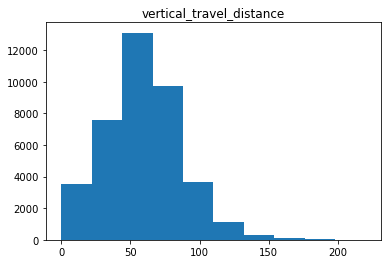

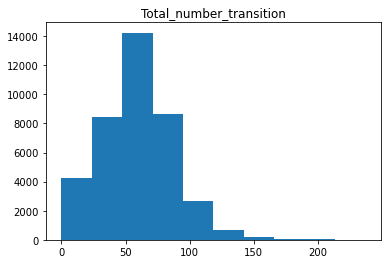

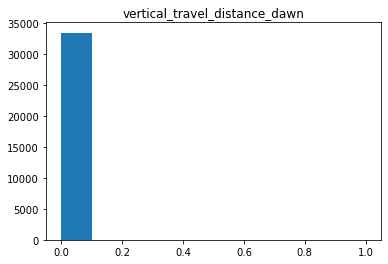

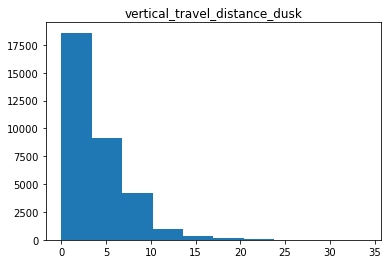

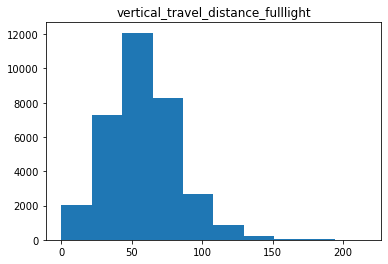

In [54]:
for x in li_transition_rest:
    plt.hist(df_daily[x])
    plt.title(x)
    plt.show()

In [56]:
df_daily[df_daily['vertical_travel_distance_dawn']>0][li_transition_rest]

,vertical_travel_distance,Total_number_transition,vertical_travel_distance_dawn,vertical_travel_distance_dusk,vertical_travel_distance_fulllight
29440,62.0,65.0,1.0,5.0,56.0
33075,76.0,74.0,1.0,8.0,67.0


In [57]:
df_daily.columns

Index(['HenID', 'level', 'duration_1_Zone', 'duration_2_Zone',
       'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone',
       'verification_daily_total_duration',
       'verification_daily_total_nbr_hour', 'dur_values',
       'dur_values_normalized', 'perc_duration_3_Zone', 'perc_duration_4_Zone',
       'perc_duration_5_Zone', 'perc_duration_2_Zone', 'perc_duration_1_Zone',
       'time_wg_open_sec', 'duration_sincedaystarted_beforeWGopened_sec',
       'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone',
       'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
       'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen',
       'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone',
       'list_of_durations', 'food_related_behavior',
       'food_related_behavior_rp', 'food_related_behavior_rm',
       'nestboxes_related_behavior', 'list_of_zones', 'list_Z4',
       'mid_cum_Z4_sec', 'Total_number_transition', 'nbr_stays',
       'distribution_ent

In [58]:
#stay
li_nbr_stays = ['nbr_stays_1_Zone', 'nbr_stays_2_Zone', 'nbr_stays_3_Zone', 'nbr_stays_4_Zone', 'nbr_stays_5_Zone']
df_daily[li_nbr_stays+['nbr_stays_total','nbr_h_per_day','Total_number_transition']]

,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone,nbr_stays_total,nbr_h_per_day,Total_number_transition
0,NaN,0.0,0.0,0.0,1.0,1.0,9,0.0
1,NaN,0.0,1.0,1.0,2.0,4.0,9,3.0
2,NaN,1.0,2.0,1.0,1.0,5.0,9,4.0
3,NaN,3.0,3.0,0.0,0.0,6.0,8,5.0
4,NaN,5.0,3.0,0.0,2.0,10.0,9,9.0
...,...,...,...,...,...,...,...,...
39625,12.0,27.0,26.0,16.0,6.0,87.0,15,86.0
39626,13.0,32.0,27.0,14.0,6.0,92.0,15,91.0
39627,21.0,42.0,28.0,14.0,5.0,110.0,15,109.0
39628,22.0,41.0,25.0,14.0,6.0,108.0,15,107.0


In [59]:
#duration
li_dur = ['duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone']
li_perc = ['perc_'+c for c in li_dur]
df_daily[li_dur+li_perc]

,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,perc_duration_1_Zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone
0,NaN,0.0,0.0,0.0,32400.0,NaN,0.0,0.0,0.0,100.0
1,NaN,0.0,780.0,325.0,31295.0,NaN,0.0,2.0,1.0,97.0
2,NaN,206.0,249.0,130.0,31815.0,NaN,1.0,1.0,0.0,98.0
3,NaN,24385.0,4415.0,0.0,0.0,NaN,85.0,15.0,0.0,0.0
4,NaN,22511.0,5946.0,0.0,3943.0,NaN,69.0,18.0,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...
39625,3736.0,30464.0,5678.0,3584.0,10538.0,7.0,56.0,11.0,7.0,20.0
39626,7927.0,24226.0,5714.0,4269.0,11864.0,15.0,45.0,11.0,8.0,22.0
39627,9643.0,22803.0,6564.0,5669.0,9321.0,18.0,42.0,12.0,10.0,17.0
39628,9020.0,24893.0,6302.0,4211.0,9574.0,17.0,46.0,12.0,8.0,18.0


In [60]:
#verify Total_number_zone==1 if and only if Total_number_transitions==0
display(df_daily[df_daily['Total_number_transition']==0][['Total_number_transition','HenID','level','Total_number_zone']].head(3))
display(df_daily[df_daily['Total_number_zone']==1][['Total_number_transition','HenID','level','Total_number_zone']].head(3))
if df_daily[(df_daily['Total_number_zone']==1)|(df_daily['Total_number_transition']==0)].shape[0]!=df_daily[(df_daily['Total_number_zone']==1)&(df_daily['Total_number_transition']==0)].shape[0]:
    print('ERROR: you dont have: Total_number_zone==1 if and only if Total_number_transitions==0')
    sys.exit()

,Total_number_transition,HenID,level,Total_number_zone
0,0.0,hen_130,2020-10-05,1.0
115,0.0,hen_134,2020-10-01,1.0
117,0.0,hen_134,2020-10-04,1.0


,Total_number_transition,HenID,level,Total_number_zone
0,0.0,hen_130,2020-10-05,1.0
115,0.0,hen_134,2020-10-01,1.0
117,0.0,hen_134,2020-10-04,1.0


In [61]:
#random bird
h = 'hen_130'
d = dt.datetime(2020,10,7)
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_transition_rest].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct

,HenID,level,PenID,vertical_travel_distance,Total_number_transition,vertical_travel_distance_dawn,vertical_travel_distance_dusk,vertical_travel_distance_fulllight
2,hen_130,2020-10-07,10,4.0,4.0,NaN,NaN,NaN


((Timestamp('2020-10-07 09:03:45'), '2_Zone'),
 (Timestamp('2020-10-07 09:07:11'), '3_Zone'),
 (Timestamp('2020-10-07 09:07:35'), '4_Zone'),
 (Timestamp('2020-10-07 09:09:45'), '5_Zone'))

In [62]:
#another random bird
h = 'hen_30'
d = dt.datetime(2020,10,4) #9h-18h
df = df_init[(df_init['HenID']==h)&(df_init['Timestamp']<=dt.datetime(2020,10,4,18,0,0))]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_transition_rest].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#vertical_travel_distance: 23 is correct (note: it came from 5 to 2 at 12:20:20)
#down_missingZone_mvtPerc corret: 2/20*100=10% (one from 5 to 2 and one from 4 to 2), we had 20 transitions
#--> correct

,HenID,level,PenID,vertical_travel_distance,Total_number_transition,vertical_travel_distance_dawn,vertical_travel_distance_dusk,vertical_travel_distance_fulllight
18254,hen_30,2020-10-04,3,23.0,20.0,NaN,NaN,NaN


((Timestamp('2020-09-29 09:44:28'), '3_Zone'),
 (Timestamp('2020-09-29 09:47:41'), '2_Zone'),
 (Timestamp('2020-09-29 09:52:07'), '5_Zone'),
 (Timestamp('2020-09-29 15:22:48'), '3_Zone'),
 (Timestamp('2020-09-29 16:25:38'), '4_Zone'),
 (Timestamp('2020-09-29 16:27:06'), '5_Zone'),
 (Timestamp('2020-10-01 17:03:23'), '2_Zone'),
 (Timestamp('2020-10-01 17:09:42'), '3_Zone'),
 (Timestamp('2020-10-01 17:17:16'), '5_Zone'),
 (Timestamp('2020-10-02 17:13:39'), '3_Zone'),
 (Timestamp('2020-10-02 17:19:32'), '4_Zone'),
 (Timestamp('2020-10-02 17:20:28'), '5_Zone'),
 (Timestamp('2020-10-04 12:20:20'), '2_Zone'),
 (Timestamp('2020-10-04 13:21:13'), '3_Zone'),
 (Timestamp('2020-10-04 13:23:18'), '4_Zone'),
 (Timestamp('2020-10-04 13:32:01'), '2_Zone'),
 (Timestamp('2020-10-04 13:54:28'), '3_Zone'),
 (Timestamp('2020-10-04 14:08:17'), '2_Zone'),
 (Timestamp('2020-10-04 14:18:48'), '3_Zone'),
 (Timestamp('2020-10-04 14:20:46'), '2_Zone'),
 (Timestamp('2020-10-04 14:48:55'), '3_Zone'),
 (Timestamp('

In [63]:
#same bird
h = 'hen_30'
d = dt.datetime(2020,10,4) #9h-18h
df = df_init[(df_init['HenID']==h)&(df_init['Timestamp']<=dt.datetime(2020,10,4,18,0,0))]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_nbr_stays].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#vertical_travel_distance: 23 is correct (note: it came from 5 to 2 at 12:20:20)
#total_number of transition: 21 rows including 2 repetitives so its 20
#stay_longer_60sec_4_Zone: correct, it did not counted the one of <60seconds
#down_missingZone_mvtPerc corret: 2/21*100=9,5% (one from 5 to 2 and one from 4 to 2)
#stay_longer_60sec_4_Zone: correct, it did not counted the one of <60seconds
#note that the stay_* is at amximum one mroe thant the total number of transition
#total_number of transition: 21 rows including a repetition of 3_zone so its 20
#--> correct

,HenID,level,PenID,nbr_stays_1_Zone,nbr_stays_2_Zone,nbr_stays_3_Zone,nbr_stays_4_Zone,nbr_stays_5_Zone
18254,hen_30,2020-10-04,3,NaN,8.0,8.0,3.0,2.0


((Timestamp('2020-09-29 09:44:28'), '3_Zone'),
 (Timestamp('2020-09-29 09:47:41'), '2_Zone'),
 (Timestamp('2020-09-29 09:52:07'), '5_Zone'),
 (Timestamp('2020-09-29 15:22:48'), '3_Zone'),
 (Timestamp('2020-09-29 16:25:38'), '4_Zone'),
 (Timestamp('2020-09-29 16:27:06'), '5_Zone'),
 (Timestamp('2020-10-01 17:03:23'), '2_Zone'),
 (Timestamp('2020-10-01 17:09:42'), '3_Zone'),
 (Timestamp('2020-10-01 17:17:16'), '5_Zone'),
 (Timestamp('2020-10-02 17:13:39'), '3_Zone'),
 (Timestamp('2020-10-02 17:19:32'), '4_Zone'),
 (Timestamp('2020-10-02 17:20:28'), '5_Zone'),
 (Timestamp('2020-10-04 12:20:20'), '2_Zone'),
 (Timestamp('2020-10-04 13:21:13'), '3_Zone'),
 (Timestamp('2020-10-04 13:23:18'), '4_Zone'),
 (Timestamp('2020-10-04 13:32:01'), '2_Zone'),
 (Timestamp('2020-10-04 13:54:28'), '3_Zone'),
 (Timestamp('2020-10-04 14:08:17'), '2_Zone'),
 (Timestamp('2020-10-04 14:18:48'), '3_Zone'),
 (Timestamp('2020-10-04 14:20:46'), '2_Zone'),
 (Timestamp('2020-10-04 14:48:55'), '3_Zone'),
 (Timestamp('

In [65]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_nbr_stays]
li_var_TODO = [i for i in li_var_TODO if i not in li_transition_rest]
#li_var_TODO = [i for i in li_var_TODO if i not in li_nbr_stays_perh]
print(len(li_var_TODO))

43


## duration

In [66]:
li_dur = [i for i in li_var_TODO if ('duration' in i)&('Nestbox' not in i)&('WG' not in i)&('night' not in i)]
li_dur

['duration_1_Zone',
 'duration_2_Zone',
 'duration_3_Zone',
 'duration_4_Zone',
 'duration_5_Zone',
 'verification_daily_total_duration',
 'perc_duration_3_Zone',
 'perc_duration_4_Zone',
 'perc_duration_5_Zone',
 'perc_duration_2_Zone',
 'perc_duration_1_Zone',
 'list_of_durations']

In [67]:
df_daily[['duration_3_Zone','verification_daily_total_duration','perc_duration_3_Zone']]

,duration_3_Zone,verification_daily_total_duration,perc_duration_3_Zone
0,0.0,32400.0,0.0
1,780.0,32400.0,2.0
2,249.0,32400.0,1.0
3,4415.0,28800.0,15.0
4,5946.0,32400.0,18.0
...,...,...,...
39625,5678.0,54000.0,11.0
39626,5714.0,54000.0,11.0
39627,6564.0,54000.0,12.0
39628,6302.0,54000.0,12.0


In [68]:
#same bird
h = 'hen_130'
d = dt.datetime(2020,10,7) #9h-18h is the day
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_dur].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#duration_*_zone, correct:
display(dt.datetime(2020,10,7,9,3,45)-dt.datetime(2020,10,7,9,0,0),#zone 3 #225
dt.datetime(2020,10,7,9,7,11)-dt.datetime(2020,10,7,9,3,45), #zone 2 #206
dt.datetime(2020,10,7,9,7,35)-dt.datetime(2020,10,7,9,7,11), #zone 3 #24
dt.datetime(2020,10,7,9,9,45)-dt.datetime(2020,10,7,9,7,35), #zone 4 #130
dt.datetime(2020,10,7,18,0,0)-dt.datetime(2020,10,7,9,9,45)) #zone 5 #31815
#rest also correct
#--> correct (should all be in seconds except when explicitely written "_mn")

,HenID,level,PenID,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,list_of_durations
2,hen_130,2020-10-07,10,NaN,206.0,249.0,130.0,31815.0,32400.0,1.0,0.0,98.0,1.0,NaN,"[225.0, 206.0, 24.0, 130.0, 31815.0]"


((Timestamp('2020-10-07 09:03:45'), '2_Zone'),
 (Timestamp('2020-10-07 09:07:11'), '3_Zone'),
 (Timestamp('2020-10-07 09:07:35'), '4_Zone'),
 (Timestamp('2020-10-07 09:09:45'), '5_Zone'))

datetime.timedelta(seconds=225)

datetime.timedelta(seconds=206)

datetime.timedelta(seconds=24)

datetime.timedelta(seconds=130)

datetime.timedelta(seconds=31815)

In [69]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_dur]
print(len(li_var_TODO))

31


## Nestbox

In [70]:
li_nb = [i for i in li_var_TODO if ('nestbox' in i.lower())|('z4' in i.lower())]
li_nb

['nestboxes_related_behavior',
 'list_Z4',
 'mid_cum_Z4_sec',
 'time_midduratioZ4_h']

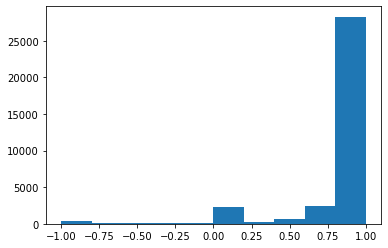

In [71]:
plt.hist(df_daily['nestboxes_related_behavior']);

In [72]:
#should be nan:
display(df_daily[df_daily['level']>dt.datetime(2021,8,15,0,0,0)]['nestboxes_related_behavior'])
#if spent less than 15minutes in total in the nestbox zone: should be 0
df_daily[df_daily['duration_4_Zone']<15*60]['nestboxes_related_behavior']

Series([], Name: nestboxes_related_behavior, dtype: float64)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
39426    0.0
39430    0.0
39433    0.0
39436    0.0
39611    0.0
Name: nestboxes_related_behavior, Length: 1786, dtype: float64

In [73]:
#ATTENTION: nestboxes_related_behavior only once the barn schedule is stable!
display(df_daily[(df_daily['nestboxes_related_behavior']<0)&(df_daily['DIB']>50)].head(2))
h = 'hen_134'
d = dt.datetime(2021,1,8) #late date to have nestbox usage
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_nb].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
display((dt.datetime(2020,11,22,5,13,10)-dt.datetime(2020,11,22,4,45,21)).total_seconds())
display((dt.datetime(2020,11,22,4,45,21)-dt.datetime(2020,11,22,4,15,21)).total_seconds())
#CORRECT!
#Note that: B10h_Nestbox_nbrvisit is the number of visits DURING DAY TIME in the test box

,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,correct_amount_of_hour,DOA,WOA,DIB,WIB,TrackingSystemID,Is_Sleeping_UP,SleepingHeight,time_midduratioZ4_h,vertical_travel_distance_fulllight
206,hen_134,2021-01-08,1194.0,18352.0,12268.0,3409.0,18777.0,54000.0,15.0,"[1194.0, 18352.0, 12268.0, 3409.0, 18777.0]",...,True,219,32,101,15,TrackingSystem 10-12,True,3,10.923056,118.0
241,hen_134,2021-02-19,1854.0,16071.0,5246.0,6573.0,24256.0,54000.0,15.0,"[1854.0, 16071.0, 5246.0, 6573.0, 24256.0]",...,True,261,38,143,21,TrackingSystem 10-12,True,3,6.999167,68.0


,HenID,level,PenID,nestboxes_related_behavior,list_Z4,mid_cum_Z4_sec,time_midduratioZ4_h
206,hen_134,2021-01-08,10,-1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",32123.0,10.923056


((Timestamp('2021-01-08 02:06:01'), '2_Zone'),
 (Timestamp('2021-01-08 02:43:01'), '3_Zone'),
 (Timestamp('2021-01-08 03:01:11'), '2_Zone'),
 (Timestamp('2021-01-08 03:24:57'), '3_Zone'),
 (Timestamp('2021-01-08 03:29:06'), '5_Zone'),
 (Timestamp('2021-01-08 03:52:53'), '2_Zone'),
 (Timestamp('2021-01-08 04:05:43'), '3_Zone'),
 (Timestamp('2021-01-08 04:11:52'), '2_Zone'),
 (Timestamp('2021-01-08 04:20:27'), '3_Zone'),
 (Timestamp('2021-01-08 04:24:04'), '5_Zone'),
 (Timestamp('2021-01-08 04:27:05'), '3_Zone'),
 (Timestamp('2021-01-08 04:29:12'), '5_Zone'),
 (Timestamp('2021-01-08 04:30:51'), '3_Zone'),
 (Timestamp('2021-01-08 05:32:45'), '2_Zone'),
 (Timestamp('2021-01-08 05:50:38'), '3_Zone'),
 (Timestamp('2021-01-08 05:57:49'), '5_Zone'),
 (Timestamp('2021-01-08 06:01:39'), '3_Zone'),
 (Timestamp('2021-01-08 06:12:08'), '5_Zone'),
 (Timestamp('2021-01-08 07:15:04'), '3_Zone'),
 (Timestamp('2021-01-08 07:18:31'), '5_Zone'),
 (Timestamp('2021-01-08 07:22:42'), '2_Zone'),
 (Timestamp('

1669.0

1800.0

In [74]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_nb]
print(len(li_var_TODO))
display(li_var_TODO)

27


['HenID',
 'level',
 'verification_daily_total_nbr_hour',
 'dur_values',
 'dur_values_normalized',
 'time_wg_open_sec',
 'duration_sincedaystarted_beforeWGopened_sec',
 'perc_1_Zone_while_WG_open',
 'nbr_h_WGopen',
 'food_related_behavior',
 'food_related_behavior_rp',
 'food_related_behavior_rm',
 'list_of_zones',
 'nbr_stays',
 'distribution_entropy',
 'nbr_stays_total',
 'PenID',
 'early_death',
 'Treatment',
 'nbr_h_per_day',
 'correct_amount_of_hour',
 'DOA',
 'WOA',
 'DIB',
 'WIB',
 'TrackingSystemID',
 'Is_Sleeping_UP']

## WG

In [75]:
#latency should be FirstTimestamp_1_Zone_sec-duration_sincedaystarted_beforeWGopened_sec: nbr of seconds since opened
df_daily[['level','nbr_h_WGopen','FirstTimestamp_1_Zone','FirstTimestamp_1_Zone_sec','duration_sincedaystarted_beforeWGopened_sec','latency_1_Zone_h']]

,level,nbr_h_WGopen,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,duration_sincedaystarted_beforeWGopened_sec,latency_1_Zone_h
0,2020-10-05,0.000000,NaT,NaN,39600.0,NaN
1,2020-10-06,0.000000,NaT,NaN,39600.0,NaN
2,2020-10-07,0.000000,NaT,NaN,39600.0,NaN
3,2020-09-30,0.000000,NaT,NaN,39600.0,NaN
4,2020-10-01,0.000000,NaT,NaN,39600.0,NaN
...,...,...,...,...,...,...
39625,2021-07-21,8.500000,2021-07-21 08:08:54,29334.0,28800.0,0.148333
39626,2021-07-22,8.333333,2021-07-22 09:17:02,33422.0,28800.0,1.283889
39627,2021-07-23,8.333333,2021-07-23 08:37:52,31072.0,28800.0,0.631111
39628,2021-07-24,8.333333,2021-07-24 08:10:45,29445.0,28800.0,0.179167


In [76]:
#check when close: all is nan
df_daily[df_daily['nbr_h_WGopen']==0][['HenID','nbr_h_WGopen','level','FirstTimestamp_1_Zone','FirstTimestamp_1_Zone_sec','duration_sincedaystarted_beforeWGopened_sec',
                                       'latency_1_Zone_h']]

,HenID,nbr_h_WGopen,level,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,duration_sincedaystarted_beforeWGopened_sec,latency_1_Zone_h
0,hen_130,0.0,2020-10-05,NaT,NaN,39600.0,NaN
1,hen_130,0.0,2020-10-06,NaT,NaN,39600.0,NaN
2,hen_130,0.0,2020-10-07,NaT,NaN,39600.0,NaN
3,hen_131,0.0,2020-09-30,NaT,NaN,39600.0,NaN
4,hen_131,0.0,2020-10-01,NaT,NaN,39600.0,NaN
...,...,...,...,...,...,...,...
39470,hen_98,0.0,2021-01-12,NaT,NaN,36000.0,NaN
39493,hen_98,0.0,2021-02-13,NaT,NaN,38400.0,NaN
39494,hen_98,0.0,2021-02-14,NaT,NaN,38400.0,NaN
39497,hen_98,0.0,2021-02-17,NaT,NaN,36000.0,NaN


In [78]:
#latency for birds never going outside
df_daily[(df_daily['level']>dt.datetime(2021,2,2))&(df_daily['FirstTimestamp_1_Zone'].isnull())][['level','FirstTimestamp_1_Zone','FirstTimestamp_1_Zone_sec','duration_sincedaystarted_beforeWGopened_sec','latency_1_Zone_h']]

,level,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,duration_sincedaystarted_beforeWGopened_sec,latency_1_Zone_h
234,2021-02-12,NaT,NaN,43200.0,1.500000
235,2021-02-13,NaT,NaN,38400.0,NaN
236,2021-02-14,NaT,NaN,38400.0,NaN
239,2021-02-17,NaT,NaN,36000.0,NaN
258,2021-03-08,NaT,NaN,36000.0,6.500000
...,...,...,...,...,...
39494,2021-02-14,NaT,NaN,38400.0,NaN
39497,2021-02-17,NaT,NaN,36000.0,NaN
39513,2021-03-06,NaT,NaN,36000.0,6.833333
39533,2021-03-26,NaT,NaN,48600.0,3.000000


In [79]:
li_wg = [i for i in li_var_TODO if 'WG' in i]+[i for i in df_daily.columns if '1_Zone' in i]+['duration_1_Zone']
li_wg
#'in_WG_15mnAfterOpening', 'Max_duration_WG', latency1_zone, perc_1_Zone_while_WG_open

['duration_sincedaystarted_beforeWGopened_sec',
 'perc_1_Zone_while_WG_open',
 'nbr_h_WGopen',
 'duration_1_Zone',
 'perc_duration_1_Zone',
 'perc_1_Zone_while_WG_open',
 'FirstTimestamp_1_Zone',
 'FirstTimestamp_1_Zone_sec',
 'latency_1_Zone_h',
 'nbr_stays_1_Zone',
 'duration_1_Zone']

In [80]:
#should nly be nan as WG not opened
print(config.date_first_opening_WG)
df_daily[df_daily['level']<config.date_first_opening_WG][['HenID','level']+li_wg]

2020-10-08 00:00:00


,HenID,level,duration_sincedaystarted_beforeWGopened_sec,perc_1_Zone_while_WG_open,nbr_h_WGopen,duration_1_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,latency_1_Zone_h,nbr_stays_1_Zone,duration_1_Zone
0,hen_130,2020-10-05,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,hen_130,2020-10-06,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,hen_130,2020-10-07,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,hen_131,2020-09-30,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,hen_131,2020-10-01,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39374,hen_98,2020-09-30,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
39375,hen_98,2020-10-01,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
39376,hen_98,2020-10-02,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN
39377,hen_98,2020-10-06,39600.0,NaN,0.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN


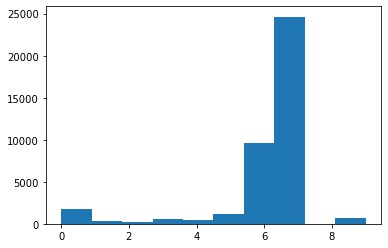

In [81]:
plt.hist(df_daily['nbr_h_WGopen']);

In [82]:
df_daily[df_daily['level']>=config.date_first_opening_WG][['HenID','level','is_mvt_night']+li_wg].tail(5)

,HenID,level,is_mvt_night,duration_sincedaystarted_beforeWGopened_sec,perc_1_Zone_while_WG_open,nbr_h_WGopen,duration_1_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,latency_1_Zone_h,nbr_stays_1_Zone,duration_1_Zone
39625,hen_98,2021-07-21,1.0,28800.0,12.209150,8.500000,3736.0,7.0,12.209150,2021-07-21 08:08:54,29334.0,0.148333,12.0,3736.0
39626,hen_98,2021-07-22,1.0,28800.0,26.423333,8.333333,7927.0,15.0,26.423333,2021-07-22 09:17:02,33422.0,1.283889,13.0,7927.0
39627,hen_98,2021-07-23,0.0,28800.0,32.143333,8.333333,9643.0,18.0,32.143333,2021-07-23 08:37:52,31072.0,0.631111,21.0,9643.0
39628,hen_98,2021-07-24,0.0,28800.0,30.066667,8.333333,9020.0,17.0,30.066667,2021-07-24 08:10:45,29445.0,0.179167,22.0,9020.0
39629,hen_98,2021-07-25,0.0,28800.0,30.092593,9.000000,9750.0,18.0,30.092593,2021-07-25 08:33:14,30794.0,0.553889,21.0,9750.0


In [83]:
#bird based on : df_daily[df_daily['Max_duration_WG']>0].tail(15)
h = 'hen_98'
d = dt.datetime(2021,1,10)  #10h a 16h20(to be checked with new data)
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_wg].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
#-->correct

,HenID,level,PenID,duration_sincedaystarted_beforeWGopened_sec,perc_1_Zone_while_WG_open,nbr_h_WGopen,duration_1_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,latency_1_Zone_h,nbr_stays_1_Zone,duration_1_Zone
39468,hen_98,2021-01-10,9,36000.0,0.270833,6.666667,65.0,0.0,0.270833,2021-01-10 12:59:40,46780.0,2.994444,1.0,65.0


((Timestamp('2021-01-10 06:26:34'), '4_Zone'),
 (Timestamp('2021-01-10 08:55:57'), '3_Zone'),
 (Timestamp('2021-01-10 08:56:20'), '2_Zone'),
 (Timestamp('2021-01-10 09:15:07'), '3_Zone'),
 (Timestamp('2021-01-10 09:33:12'), '4_Zone'),
 (Timestamp('2021-01-10 09:33:43'), '5_Zone'),
 (Timestamp('2021-01-10 09:34:41'), '4_Zone'),
 (Timestamp('2021-01-10 09:34:58'), '3_Zone'),
 (Timestamp('2021-01-10 09:35:05'), '2_Zone'),
 (Timestamp('2021-01-10 09:49:14'), '3_Zone'),
 (Timestamp('2021-01-10 10:12:51'), '4_Zone'),
 (Timestamp('2021-01-10 10:14:11'), '5_Zone'),
 (Timestamp('2021-01-10 12:45:55'), '4_Zone'),
 (Timestamp('2021-01-10 12:46:06'), '3_Zone'),
 (Timestamp('2021-01-10 12:46:08'), '2_Zone'),
 (Timestamp('2021-01-10 12:59:40'), '1_Zone'),
 (Timestamp('2021-01-10 13:00:45'), '2_Zone'),
 (Timestamp('2021-01-10 13:09:21'), '3_Zone'),
 (Timestamp('2021-01-10 13:24:26'), '2_Zone'),
 (Timestamp('2021-01-10 14:01:36'), '3_Zone'),
 (Timestamp('2021-01-10 14:03:43'), '4_Zone'),
 (Timestamp('

In [84]:
#random bird
h = 'hen_12'
d = dt.datetime(2021,1,9)  #10h a 16h20(to be checked with new data)
df = df_init[(df_init['HenID']==h)&(df_init['date']==d)]
display(df_daily[(df_daily['HenID']==h)&(df_daily['level']==d)][li_general+li_wg].sort_values(['level']))
display(tuple(zip(df['Timestamp'].tolist(),df['Zone'].tolist())))
display(dt.datetime(2021,1,15,9,14)-dt.datetime(2021,1,15,8,58),
       dt.datetime(2021,1,15,10,55)-dt.datetime(2021,1,15,9,23))
#Correct

,HenID,level,PenID,duration_sincedaystarted_beforeWGopened_sec,perc_1_Zone_while_WG_open,nbr_h_WGopen,duration_1_Zone,perc_duration_1_Zone,perc_1_Zone_while_WG_open,FirstTimestamp_1_Zone,FirstTimestamp_1_Zone_sec,latency_1_Zone_h,nbr_stays_1_Zone,duration_1_Zone
25931,hen_12,2021-01-09,5,36000.0,0.393162,6.5,92.0,0.0,0.393162,2021-01-09 15:09:23,54563.0,5.156389,1.0,92.0


((Timestamp('2021-01-09 03:44:18'), '4_Zone'),
 (Timestamp('2021-01-09 04:45:58'), '3_Zone'),
 (Timestamp('2021-01-09 05:17:19'), '2_Zone'),
 (Timestamp('2021-01-09 05:27:22'), '3_Zone'),
 (Timestamp('2021-01-09 05:56:31'), '2_Zone'),
 (Timestamp('2021-01-09 06:04:43'), '3_Zone'),
 (Timestamp('2021-01-09 06:11:59'), '4_Zone'),
 (Timestamp('2021-01-09 06:12:13'), '5_Zone'),
 (Timestamp('2021-01-09 09:47:05'), '4_Zone'),
 (Timestamp('2021-01-09 09:47:22'), '3_Zone'),
 (Timestamp('2021-01-09 09:47:37'), '2_Zone'),
 (Timestamp('2021-01-09 10:15:32'), '3_Zone'),
 (Timestamp('2021-01-09 10:15:56'), '4_Zone'),
 (Timestamp('2021-01-09 10:17:24'), '5_Zone'),
 (Timestamp('2021-01-09 14:51:38'), '4_Zone'),
 (Timestamp('2021-01-09 14:51:54'), '3_Zone'),
 (Timestamp('2021-01-09 14:52:03'), '2_Zone'),
 (Timestamp('2021-01-09 15:09:23'), '1_Zone'),
 (Timestamp('2021-01-09 15:10:55'), '2_Zone'),
 (Timestamp('2021-01-09 15:23:51'), '3_Zone'),
 (Timestamp('2021-01-09 15:32:18'), '4_Zone'),
 (Timestamp('

datetime.timedelta(seconds=960)

datetime.timedelta(seconds=5520)

In [85]:
#update the list of variable that we still need to verify
li_var_TODO = [i for i in li_var_TODO if i not in li_wg]
print(len(li_var_TODO))
display(li_var_TODO)

24


['HenID',
 'level',
 'verification_daily_total_nbr_hour',
 'dur_values',
 'dur_values_normalized',
 'time_wg_open_sec',
 'food_related_behavior',
 'food_related_behavior_rp',
 'food_related_behavior_rm',
 'list_of_zones',
 'nbr_stays',
 'distribution_entropy',
 'nbr_stays_total',
 'PenID',
 'early_death',
 'Treatment',
 'nbr_h_per_day',
 'correct_amount_of_hour',
 'DOA',
 'WOA',
 'DIB',
 'WIB',
 'TrackingSystemID',
 'Is_Sleeping_UP']

# entropy

In [86]:
df_daily[['distribution_entropy','list_of_zones','dur_values_normalized','dur_values']]

,distribution_entropy,list_of_zones,dur_values_normalized,dur_values
0,0.000000,['5_Zone'],"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 32400.0]"
1,0.244385,"['5_Zone', '3_Zone', '4_Zone', '5_Zone']","[0.0, 0.0, 0.024074074074074074, 0.01003086419...","[0.0, 0.0, 780.0, 325.0, 31295.0]"
2,0.158130,"['3_Zone', '2_Zone', '3_Zone', '4_Zone', '5_Zo...","[0.0, 0.006358024691358025, 0.0076851851851851...","[0.0, 206.0, 249.0, 130.0, 31815.0]"
3,0.618034,"['3_Zone', '2_Zone', '3_Zone', '2_Zone', '3_Zo...","[0.0, 0.8467013888888889, 0.15329861111111112,...","[0.0, 24385.0, 4415.0, 0.0, 0.0]"
4,1.183695,"['2_Zone', '3_Zone', '2_Zone', '3_Zone', '5_Zo...","[0.0, 0.6947839506172839, 0.18351851851851853,...","[0.0, 22511.0, 5946.0, 0.0, 3943.0]"
...,...,...,...,...
39625,1.793944,"['3_Zone', '4_Zone', '3_Zone', '2_Zone', '3_Zo...","[0.06918518518518518, 0.5641481481481482, 0.10...","[3736.0, 30464.0, 5678.0, 3584.0, 10538.0]"
39626,2.037801,"['4_Zone', '3_Zone', '4_Zone', '3_Zone', '2_Zo...","[0.14679629629629629, 0.44862962962962966, 0.1...","[7927.0, 24226.0, 5714.0, 4269.0, 11864.0]"
39627,2.117442,"['4_Zone', '3_Zone', '2_Zone', '3_Zone', '2_Zo...","[0.17857407407407408, 0.42227777777777775, 0.1...","[9643.0, 22803.0, 6564.0, 5669.0, 9321.0]"
39628,2.037459,"['4_Zone', '3_Zone', '2_Zone', '3_Zone', '2_Zo...","[0.16703703703703704, 0.4609814814814815, 0.11...","[9020.0, 24893.0, 6302.0, 4211.0, 9574.0]"


In [87]:
from scipy.stats import entropy
#Note: order does not matter, number of 0min in a zone does not matter
print(entropy([0.0, 0.0, 780.0, 325.0, 31295.0], base=2),
entropy([0.0, 206.0, 249.0, 130.0, 31815.0,0,0,0,0], base=2),
entropy([0.0, 206.0, 249.0, 130.0, 31815.0], base=2),
entropy([1/6, 1/6, 1/6, 1/6, 1/6, 1/6], base=2),
entropy([1/5, 1/5, 1/5, 1/5, 1/5], base=2),
entropy([1/4, 1/4, 1/4, 1/4], base=2))

0.24438458187120013 0.15812999407546002 0.15812999407546005 2.584962500721156 2.3219280948873626 2.0


In [88]:
#max entropy with 5 zones
nbr_zone = 5
print(math.log(nbr_zone, 2), entropy([1,1,1,1,1],base=2))
if round(math.log(nbr_zone, 2),8)!=round(entropy([1,1,1,1,1],base=2),8):
    print('ERROR 1')
    sys.exit()
if df_daily['distribution_entropy'].max()>math.log(nbr_zone, 2):
    print('ERROR 2')
    sys.exit()

2.321928094887362 2.3219280948873626


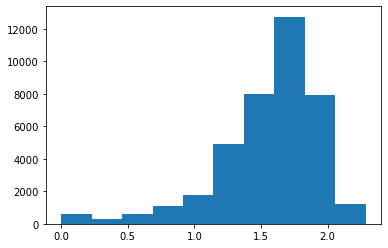

In [89]:
plt.hist(df_daily['distribution_entropy']);

## Other

In [90]:
df_daily['verification_daily_total_duration'].value_counts()

54000.0    33483
43200.0     1210
46800.0     1057
50400.0     1016
39600.0      928
32400.0      814
36000.0      529
28800.0      143
Name: verification_daily_total_duration, dtype: int64

In [91]:
df_daily[df_daily['verification_daily_total_duration']==28800]['level'].value_counts() #on the 30 septemebr: 9h-17h was the 
#light on: 8h=28'800
#2020-09-30: first full day, but for the chicken that never moved since they enter the day before, they still hav no data
#Correct!

2020-09-30    143
Name: level, dtype: int64

In [92]:
display(df_daily[df_daily['verification_daily_total_duration']<28800]['HenID'].value_counts())
df_daily[df_daily['verification_daily_total_duration']<28800]['level'].value_counts()
#2020-09-30: first full day, but for the chicken that never moved since they enter the day before, they still hav no data

Series([], Name: HenID, dtype: int64)

Series([], Name: level, dtype: int64)

In [93]:
df_daily[df_daily['verification_daily_total_duration']<28800][li_general+['verification_daily_total_duration']+\
                                                               li_first_timestamp]
#can appear in any zone... we dont know from when on, where th ebird was before going there, so we can only remove those days
#for those specific chickens
#TODO at the end of experiment: CHECK ALL CASES ONE BY ONE

,HenID,level,PenID,verification_daily_total_duration,FirstTimestamp_1_Zone,FirstTimestamp_2_Zone,FirstTimestamp_3_Zone,FirstTimestamp_4_Zone,FirstTimestamp_5_Zone,FirstTimestamp_1_Zone_sec,Total_number_zone


# Save and last verification

In [94]:
li_dur = ['duration_1_Zone','duration_2_Zone','duration_3_Zone','duration_4_Zone','duration_5_Zone']
for x in li_dur:
    df_daily[x+'_min'] = df_daily[x].map(lambda x: x/60)

In [95]:
print(list(df_daily.columns))
df_daily_ = df_daily.drop(['list_of_zones','dur_values_normalized','list_Z4']+li_dur,axis=1)

['HenID', 'level', 'duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone', 'verification_daily_total_duration', 'verification_daily_total_nbr_hour', 'dur_values', 'dur_values_normalized', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone', 'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec', 'duration_sincedaystarted_beforeWGopened_sec', 'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone', 'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen', 'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone', 'list_of_durations', 'food_related_behavior', 'food_related_behavior_rp', 'food_related_behavior_rm', 'nestboxes_related_behavior', 'list_of_zones', 'list_Z4', 'mid_cum_Z4_sec', 'Total_number_transition', 'nbr_stays', 'distribution_entropy', 'vertical_travel_distance', 'vertical_travel_distance_dawn', 'vertical_travel_distance_dusk', 'nbr_stays

In [96]:
df_daily_.to_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'),sep=';',index=False)
print(df_daily_.shape)
df_daily_.head(3)

(39180, 69)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,TrackingSystemID,Is_Sleeping_UP,SleepingHeight,time_midduratioZ4_h,vertical_travel_distance_fulllight,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min
0,hen_130,2020-10-05,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",0.0,0.0,100.0,0.0,NaN,...,TrackingSystem 10-12,True,3,NaN,NaN,NaN,0.000000,0.00,0.000000,540.000000
1,hen_130,2020-10-06,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",2.0,1.0,97.0,0.0,NaN,...,TrackingSystem 10-12,False,1,NaN,NaN,NaN,0.000000,13.00,5.416667,521.583333
2,hen_130,2020-10-07,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",1.0,0.0,98.0,1.0,NaN,...,TrackingSystem 10-12,True,3,NaN,NaN,NaN,3.433333,4.15,2.166667,530.250000


In [97]:
df_daily['time_wg_open_sec']

0        21600.0
1        21600.0
2        21600.0
3        21600.0
4        21600.0
          ...   
39625    30600.0
39626    30000.0
39627    30000.0
39628    30000.0
39629    32400.0
Name: time_wg_open_sec, Length: 39180, dtype: float64